In [1]:
import pandas as pd
import re
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
from src.ZeroRateCurve import ExampleNSSCurve
from src.HullWhite import OneFactorHullWhiteModel
from src.Swaption import EuropeanSwaption, SwaptionType
from src.HullWhiteTreeSwaptionPricer import HullWhiteTreeEuropeanSwaptionPricer

# === Calibrated parameters (from calibration run) ===
# Calibrated a: 1.0000055399156097e-12
# Calibrated sigmas: [0.00986605 0.01080275 0.00962101 0.01165384 0.01074103 0.01170346
#  0.01175373 0.01235571 0.01267639 0.01213953 0.01226828 0.01492349]
CALIBRATED_A = 0.0018828202133317922
CALIBRATED_SIGMAS = np.array([
    0.00902488, 0.01093729, 0.0085944,  0.01283763, 0.00961361, 0.01167299,
    0.01183269, 0.01236818, 0.01252241, 0.01218863, 0.01193857, 0.014551,
])

# === Global settings ===
ZCB_CURVE = ExampleNSSCurve()
TIMESTEP = 0.25
MAX_WORKERS = 12

# === Helper functions ===
def extract_tenors(description):
    matches = re.findall(r'(\d+)([YM])', description.upper())
    tenors = []
    for amount, unit in matches:
        amount = float(amount)
        if unit == 'M':
            amount /= 12
        tenors.append(amount)

    if tenors[0] < 0.5: # ignore short expiry for now.
        print(f"Ignoring short expiry in description {description}...'")
        return None, None
    if len(tenors) >= 2:
        return tenors[0], tenors[1]
    elif len(tenors) == 1:
        return tenors[0], None
    else:
        return None, None

def price_swaption(hw_model, swap_start, swap_end, timestep):
    swaption = EuropeanSwaption(
        swaption_type=SwaptionType.PAYER,
        swap_start=swap_start,
        swap_end=swap_end,
        payment_frequency=0.5,
    )
    tree = swaption.build_valuation_tree(ZCB_CURVE, set_ATM_strike=True, 
                                         model=hw_model, timestep=timestep, verbose=False)
    return HullWhiteTreeEuropeanSwaptionPricer.price_in_bps(swaption, tree)

# === Load all available data ===
df_all = pd.read_csv("./data/swaption_quotes_ALL.csv")
df_calibration = pd.read_csv("./data/swaption_quotes_CALIBRATION.csv")
df_all = df_all.dropna()
df_all = df_all[df_all['Description'].str.contains("EUR Swaption Premium", na=False)]

# drop the ones used for calibration!
df_all = df_all[~df_all['Description'].isin(df_calibration['Description'])]

# === Initialize model ===
model = OneFactorHullWhiteModel(CALIBRATED_A)
model.set_sigmas_from_vector(CALIBRATED_SIGMAS)

# === Parallel pricing ===
def price_row(row):
    print(f"Pricing row index {row.Index}: {row.Description}...")
    swap_start, swap_dur = extract_tenors(row.Description)
    if swap_start is None or swap_dur is None:
        return np.nan
    swap_end = swap_start + swap_dur
    return price_swaption(model, swap_start, swap_end, TIMESTEP)

prices = [0.0] * len(df_all)
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    futures = {executor.submit(price_row, row): i for i, row in enumerate(df_all.itertuples())}
    for future in as_completed(futures):
        idx = futures[future]
        try:
            prices[idx] = future.result()
        except Exception as e:
            print(f"Pricing failed at index {idx}: {e}")
            prices[idx] = np.nan

df_all["Model_Premium"] = prices
df_all.dropna(inplace=True) # drop rows where pricing failed
print(f"Priced {len(df_all)} swaptions successfully.")

df_all["Abs_Error_bps"] = np.abs(df_all["Model_Premium"] - df_all["Quoted_Premium"])
df_all["Rel_Error_pct"] = 100.0 * (df_all["Model_Premium"] - df_all["Quoted_Premium"]) / df_all["Quoted_Premium"]

# === Compute metrics ===
mae = np.nanmean(df_all["Abs_Error_bps"])
rmse = np.sqrt(np.nanmean((df_all["Model_Premium"] - df_all["Quoted_Premium"]) ** 2))
mre = np.nanmean(np.abs(df_all["Rel_Error_pct"]))

print("\n===== VALIDATION RESULTS =====")
print(f"Mean Absolute Error (bps): {mae:.4f}")
print(f"Root Mean Squared Error (bps): {rmse:.4f}")
print(f"Mean Relative Error (pct): {mre:.4f}%")

# === Save results ===
df_all.to_csv("./results/swaption_validation_results.csv", index=False)
print("\nDetailed results saved to ./results/swaption_validation_results.csv")


Pricing row index 0: EUR Swaption Premium 3M10Y...
Ignoring short expiry in description EUR Swaption Premium 3M10Y...'
Pricing row index 4: EUR Swaption Premium 1M10Y...
Ignoring short expiry in description EUR Swaption Premium 1M10Y...'
Pricing row index 6: EUR Swaption Premium 1Y10Y...Pricing row index 12: EUR Swaption Premium 3M5Y...
Ignoring short expiry in description EUR Swaption Premium 3M5Y...'
Pricing row index 16: EUR Swaption Premium 2Y3Y...

Pricing row index 18: EUR Swaption Premium 4Y10Y...Pricing row index 19: EUR Swaption Premium 5Y15Y...
Pricing row index 20: EUR Swaption Premium 6Y10Y...

Pricing row index 21: EUR Swaption Premium 7Y10Y...Pricing row index 22: EUR Swaption Premium 8Y10Y...
Pricing row index 23: EUR Swaption Premium 9Y10Y...

Pricing row index 24: EUR Swaption Premium 1M20Y...Pricing row index 25: EUR Swaption Premium 2M15Y...

Ignoring short expiry in description EUR Swaption Premium 1M20Y...'
Pricing row index 26: EUR Swaption Premium 3M30Y...
Ignori

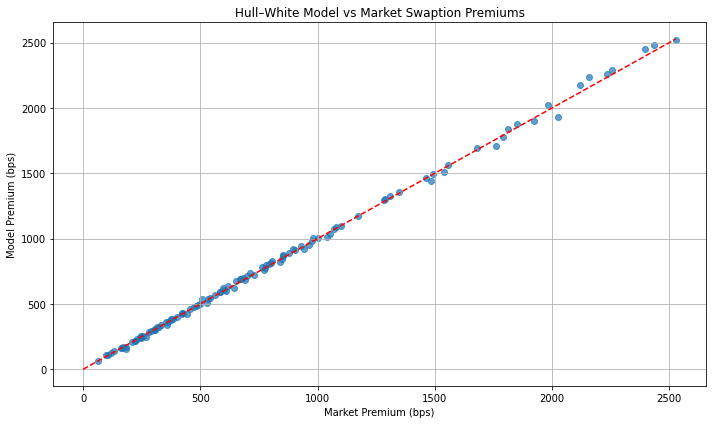

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(df_all["Quoted_Premium"], df_all["Model_Premium"], alpha=0.7)
plt.plot([0, max(df_all["Quoted_Premium"])],
         [0, max(df_all["Quoted_Premium"])], 'r--')
plt.xlabel("Market Premium (bps)")
plt.ylabel("Model Premium (bps)")
plt.title("Hull–White Model vs Market Swaption Premiums")
plt.grid(True)
plt.tight_layout()
plt.show()


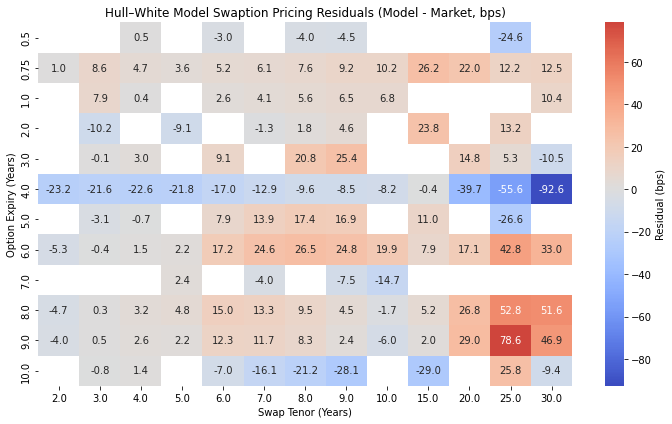

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# --- Extract expiry & tenor from description ---
def extract_tenors(description):
    matches = re.findall(r'(\d+)([YM])', description.upper())
    tenors = []
    for amount, unit in matches:
        amount = float(amount)
        if unit == 'M':
            amount /= 12
        tenors.append(amount)
    if len(tenors) >= 2:
        return tenors[0], tenors[1]
    elif len(tenors) == 1:
        return tenors[0], None
    else:
        return None, None

# --- Compute residuals ---
df_all["Expiry"], df_all["Tenor"] = zip(*df_all["Description"].map(extract_tenors))
df_all["Residual (bps)"] = df_all["Model_Premium"] - df_all["Quoted_Premium"]

# --- Pivot table for heatmap ---
heatmap_data = df_all.pivot_table(
    index="Expiry", columns="Tenor", values="Residual (bps)", aggfunc="mean"
).sort_index(ascending=True)

# --- Plot ---
plt.figure(figsize=(10,6))
sns.heatmap(
    heatmap_data,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".1f",
    cbar_kws={'label': 'Residual (bps)'}
)
plt.title("Hull–White Model Swaption Pricing Residuals (Model - Market, bps)")
plt.xlabel("Swap Tenor (Years)")
plt.ylabel("Option Expiry (Years)")
plt.tight_layout()
plt.show()


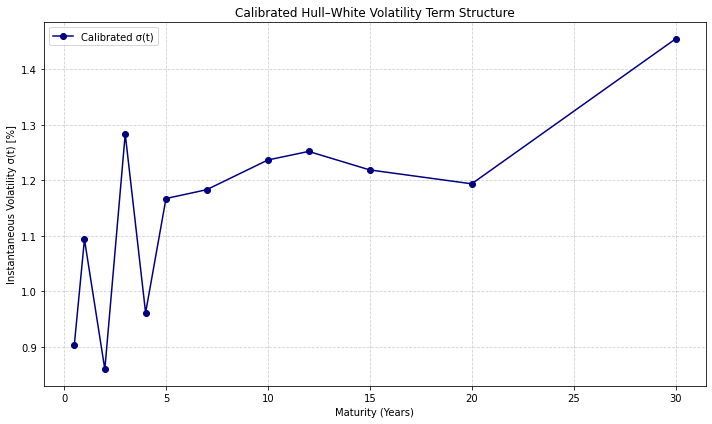

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

SIGMA_BREAKPOINTS = [0.5, 1, 2, 3, 4, 5, 7, 10, 12, 15, 20, 30]

plt.figure(figsize=(10,6))
plt.plot(SIGMA_BREAKPOINTS, CALIBRATED_SIGMAS * 100, marker='o', linestyle='-', color='navy', label='Calibrated σ(t)')
plt.xlabel("Maturity (Years)")
plt.ylabel("Instantaneous Volatility σ(t) [%]")
plt.title("Calibrated Hull–White Volatility Term Structure")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
